In [1]:
import numpy as np
import matplotlib
from datascience import *
%matplotlib inline
import matplotlib.pyplot as plt
from scipy import interpolate
from scipy.optimize import curve_fit

In [2]:
path0p01 = 'idms_0p01/nuevoScan/'
path0p05 = 'idms_0p05/nuevoScan/'
path0p1 = 'idms_0p1/nuevoScan/'
path0p5 = 'idms_0p5/nuevoScan/'
path1 = 'idms_1/nuevoScan/'
path1i = 'idm/scan1/'
path1s = 'inelasticDarkMatter/nuevoScan/'
path_exclusion = 'exclusions/'

In [3]:
def calc_mchi2(mchi1, ma, gx, f):
    vphi = ma / (2*gx)
    return mchi1 + 2*f*vphi

def calc_lim_ms2(alphad, ma):
    return ma**2 / (4*np.sqrt(np.pi)* alphad)


def calc_values(df_dat):
    mx1 = df_dat.column('Mx1')
    yf = df_dat.column('yf')
    vphi = df_dat.column('MAp') / (2*df_dat.column('gX'))
    mx2 = mx1 + 2*yf*vphi
    df_dat['Mx2'] =  mx2
    df_dat['delta'] = df_dat.column('Mx2') - df_dat.column('Mx1')
    df_dat['alphad'] = (df_dat.column('gX')**2)/(4*np.pi)
    df_dat['alphaf'] = (df_dat.column('yf')**2)/(4*np.pi)
    #df_dat['ratio_ms2_map'] = df_dat.column('Ms2')**2 / calc_lim_ms2(df_dat.column('alphad'),df_dat.column('MAp'))
    df_dat['mass_relative'] = df_dat.column('delta') / df_dat.column('Mx1')
    return df_dat

def convertir_elementos(df_):
    # Crear una copia del DataFrame original
    df = df_.copy() 
        
    # Convertir y redondear las columnas numéricas
    df['Mchi1'] = df['Mchi1'] * 1e3 
    df['MAp'] = df['MAp'] * 1e3
    df['mphi'] = df['mphi'] * 1e3
    
    # Renombrar las columnas
    df = df.relabel('Mchi1', 'Mx1')
    df = df.relabel('Mchi2', 'Mx2')
    df = df.relabel('mphi', 'Ms2')
    df = df.relabel('ff', 'yf')
    df = df.relabel('angle', 'st')
    df = calc_values(df)
    return df 


def cargado_archivos(archivos):
    """
    Combina múltiples archivos CSV en una única tabla, manejando archivos vacíos o inexistentes.

    Args:
        archivos (list): Lista de rutas de archivos CSV.

    Returns:
        Table: Tabla combinada. Si no hay archivos válidos, retorna una tabla vacía.
    """
    datos = None  # Inicializamos como None para manejar el primer archivo válido

    for archivo in archivos:
        try:
            tabla_temp = Table.read_table(archivo)
            if tabla_temp.num_rows > 0:
                if datos is None:  # Primer archivo válido
                    datos = tabla_temp
                else:
                    datos.append(tabla_temp)  # Append a la tabla existente
        except FileNotFoundError:
            print(f"Error: {archivo} no existe.")
        except Exception as e:  # Otros errores (ej: formato incorrecto)
            print(f"Error al cargar {archivo}: {str(e)}")

    return Table() if datos is None else datos  # Retorna tabla vacía si no hay datos


#Los valores reportados por Planck
val_exp = 0.12 #Valor observado
error = 0.001 #Error reportado por Planck 
#Queremos que el valor sea calculado a 3 sigma, o sea, 3 veces el error reportado por Planck 
sigma = 3
val_por = sigma *  error 
val_min = round(val_exp - val_por,3)
val_max = round(val_exp + val_por,3)

def omega(df_):
    global val_min, val_max
    df = df_.copy()
    df['Densidad reliquia'] = np.round(df.column('Densidad reliquia'),3)
    return df.where('Densidad reliquia', are.between_or_equal_to(val_min,val_max))


In [4]:
def graficar_densidad_reliquia(df):
    plt.figure(figsize=(7, 5))  # Ancho mayor para 3 gráficos


    #plt.plot(df_5.column('Mx1'), df_5.column('Densidad reliquia'),'.',color='blue',alpha=0.5)
    plt.plot(df.column('Mx1'), df.column('Densidad reliquia'), 
             '.', color='blue', alpha=0.7, markersize=8)
    plt.axhline(y=val_min, color='red', linestyle='--', linewidth=1)
    plt.axhline(y=val_max, color='red', linestyle='--', linewidth=1)
    plt.ylabel(r'$\Omega h^2$', fontsize=14)
    plt.xlabel(r'$M_{\chi_{1}}$ (GeV)', fontsize=14)
    plt.ylim(0.115, 0.125)
    plt.grid(True, linestyle='--', alpha=0.3)
    plt.xscale('log')
    plt.yscale('linear')
    
    
    plt.tight_layout()

def graficar_epsilon(df):
    plt.figure(figsize=(10,7))
    plt.plot(df.column('Mx1'), df.column('epsilon') ,'.',color='blue',alpha=0.5)
    plt.xscale('log')
    plt.yscale('log')
    plt.ylabel(r'$\epsilon$',size=20)
    plt.xlabel(r'$M_{\chi_{1}}$ (MeV)',size=20)
    plt.grid(True, linestyle='--', alpha=0.3)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    #plt.legend(fontsize=12, framealpha=0.9, loc='best')
    #plt.title(r'$\Delta \geq 2m_{e}$',size=20)
    plt.xlim(0.9,1e3+100)


def graficar_y(df_):
    df = df_.copy()
    alpha = df.column('alphad')[0]
    ratio = round((df.column('Mx1') / df.column('MAp')).item(0),3)
    factor = alpha * ratio**4 
    plt.figure(figsize=(10,7))
    plt.plot(df.column('Mx1'), df.column('epsilon')**2 * factor ,'.',color='blue',alpha=0.5)
    plt.xscale('log')
    plt.yscale('log')
    plt.ylabel(r'$y = \alpha_{D}\epsilon^2(M_{\chi_{1}}/M_{A^\prime})^{4}$',size=20)
    plt.xlabel(r'$M_{\chi_{1}}$ (MeV)',size=20)
    plt.grid(True, linestyle='--', alpha=0.3)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    #plt.legend(fontsize=12, framealpha=0.9, loc='best')
    #plt.title(r'$\Delta \geq 2m_{e}$',size=20)
    plt.xlim(0.9,1e3+100)

In [5]:

def calc_values_idm(df_dat):
    mx1 = df_dat.column('Mx1')
    mx2 = mx1 + df_dat.column('deltamass')
    df_dat['Mx2'] =  mx2
    df_dat['delta'] = df_dat.column('Mx2') - df_dat.column('Mx1')
    df_dat['alphad'] = (df_dat.column('gX')**2)/(4*np.pi)
    df_dat['mass_relative'] = df_dat.column('delta') / df_dat.column('Mx1')
    return df_dat

def convertir_elementos_idm(df_):
    # Crear una copia del DataFrame original
    df = df_.copy() 
        
    # Convertir y redondear las columnas numéricas
    df['Mchi1'] = df['Mchi1'] * 1e3 
    df['MAp'] = df['MAp'] * 1e3
    #df['mphi'] = df['mphi'] * 1e3
    
    # Renombrar las columnas
    df = df.relabel('Mchi1', 'Mx1')
    df = df.relabel('Mchi2', 'Mx2')
    df = calc_values_idm(df)
    return df 


def limite_masa_higgs_foton_oscuro(df_):
    df = df_.copy()
    factor = df.column('alphad').item(0)
    #print(factor)
    mask = df.column('Ms2')**2 <= df.column('MAp')**2 / factor
    df_filtrado = df.where(mask)
    return df_filtrado


def extrapolacion(data, label1,label2, degree=5, extension_factor=0.2):
    mass = data.column(label1)
    y = data.column(label2)
    
    coefficients = np.polyfit(mass, y, degree)
    polynomial = np.poly1d(coefficients)
    
    log_min = np.log10(min(mass) * (1 - extension_factor))
    log_max = np.log10(max(mass) * (1 + extension_factor))
    
    mass_extended = np.logspace(log_min, log_max, 500)
    y_extrapolated = polynomial(mass_extended)
    return mass_extended, y_extrapolated

In [6]:
archivos1 = [f'{path0p01}analisis_random_Delta0p011.csv',
            f'{path0p01}analisis_random_Delta0p012.csv',
            f'{path0p01}analisis_random_Delta0p013.csv',
            f'{path0p01}analisis_random_Delta0p014.csv',
            f'{path0p01}analisis_random_Delta0p015.csv',
            f'{path0p01}analisis_random_Delta0p016.csv',
            f'{path0p01}analisis_random_Delta0p017.csv',
            f'{path0p01}analisis_random_Delta0p018.csv']

df_0p01 = cargado_archivos(archivos1)

df_0p01 = convertir_elementos(df_0p01)
df_0p01.show(3)
df_omega_0p01 = omega(df_0p01)
df_omega_0p01.show(3)

MAp,Ms2,Mx1,st,gX,epsilon,yf,Mx2,Densidad reliquia,loglikelihood,delta,alphad,alphaf,mass_relative
14.9236,43.6802,4.97454,0.0005,2.50663,1.54789e-06,0.00835543,5.02429,0.403,22.0991,0.0497454,0.5,5.55556e-06,0.01
1276.23,54.9833,425.412,0.0005,2.50663,1.78119e-06,0.00835543,429.666,6.26,95.7144,4.25412,0.5,5.55556e-06,0.01
520.867,38.4047,173.622,0.0005,2.50663,4.11766e-06,0.00835543,175.358,0.259,7.23413,1.73622,0.5,5.55556e-06,0.01


MAp,Ms2,Mx1,st,gX,epsilon,yf,Mx2,Densidad reliquia,loglikelihood,delta,alphad,alphaf,mass_relative
8.40184,183.154,2.80061,0.0005,2.50663,1.99017e-06,0.00835543,2.82862,0.121,0.000465894,0.0280061,0.5,5.55556e-06,0.01
10.8332,34.4308,3.61105,0.0005,2.50663,2.32212e-06,0.00835543,3.64716,0.12,0,0.0361105,0.5,5.55556e-06,0.01
57.3524,3894.49,19.1175,0.0005,2.50663,1.10818e-05,0.00835543,19.3086,0.12,0,0.191175,0.5,5.55556e-06,0.01


In [7]:
archivos1 = [f'{path0p05}analisis_random_Delta0p051.csv',
            f'{path0p05}analisis_random_Delta0p052.csv',
            f'{path0p05}analisis_random_Delta0p053.csv',
            f'{path0p05}analisis_random_Delta0p054.csv',
            f'{path0p05}analisis_random_Delta0p055.csv',
            f'{path0p05}analisis_random_Delta0p056.csv',
            f'{path0p05}analisis_random_Delta0p057.csv',
            f'{path0p05}analisis_random_Delta0p058.csv']

df_0p05 = cargado_archivos(archivos1)

df_0p05 = convertir_elementos(df_0p05)
df_0p05.show(3)
df_omega_0p05 = omega(df_0p05)
df_omega_0p05.show(3)

MAp,Ms2,Mx1,st,gX,epsilon,yf,Mx2,Densidad reliquia,loglikelihood,delta,alphad,alphaf,mass_relative
7.48081,1.97009,2.4936,0.0001,2.50663,2.05251e-06,0.0417771,2.61828,3.49e-08,7.2,0.12468,0.5,0.000138889,0.05
13.8521,27.5809,4.61735,0.0001,2.50663,1.97415e-06,0.0417771,4.84822,0.311,12.2947,0.230868,0.5,0.000138889,0.05
379.126,6477.56,126.375,0.0001,2.50663,0.000450691,0.0417771,132.694,0.00627,6.46599,6.31877,0.5,0.000138889,0.05


MAp,Ms2,Mx1,st,gX,epsilon,yf,Mx2,Densidad reliquia,loglikelihood,delta,alphad,alphaf,mass_relative
160.278,1671.25,53.426,0.0001,2.50663,4.12944e-05,0.0417771,56.0973,0.122,0.00186147,2.6713,0.5,0.000138889,0.05
2238.52,3.31465,746.173,0.0001,2.50663,9.60994e-05,0.0417771,783.482,0.12,0,37.3086,0.5,0.000138889,0.05
2518.07,5.14444,839.358,0.0001,2.50663,0.000263633,0.0417771,881.326,0.123,0.00418354,41.9679,0.5,0.000138889,0.05


In [8]:
archivos1 = [f'{path0p1}analisis_random_Delta0p11.csv',
            f'{path0p1}analisis_random_Delta0p12.csv',
            f'{path0p1}analisis_random_Delta0p13.csv',
            f'{path0p1}analisis_random_Delta0p14.csv',
            f'{path0p1}analisis_random_Delta0p15.csv',
            f'{path0p1}analisis_random_Delta0p16.csv',
            f'{path0p1}analisis_random_Delta0p17.csv',
            f'{path0p1}analisis_random_Delta0p18.csv']

df_0p1 = cargado_archivos(archivos1)

df_0p1 = convertir_elementos(df_0p1)
df_0p1.show(3)
df_omega_0p1 = omega(df_0p1)
df_omega_0p1.show(3)

MAp,Ms2,Mx1,st,gX,epsilon,yf,Mx2,Densidad reliquia,loglikelihood,delta,alphad,alphaf,mass_relative
16.5998,1.30857,5.53325,0.0001,2.50663,3.4506e-05,0.0835543,6.08658,3.53e-07,7.19996,0.553325,0.5,0.000555556,0.1
147.327,366.161,49.109,0.0001,2.50663,0.000327086,0.0835543,54.0199,0.00586,6.51285,4.9109,0.5,0.000555556,0.1
1583.35,3.94561,527.782,0.0001,2.50663,0.000222835,0.0835543,580.56,0.00419,6.70539,52.7782,0.5,0.000555556,0.1


MAp,Ms2,Mx1,st,gX,epsilon,yf,Mx2,Densidad reliquia,loglikelihood,delta,alphad,alphaf,mass_relative
918.058,5606.6,306.019,0.0001,2.50663,0.000330276,0.0835543,336.621,0.119,0.000466938,30.6019,0.5,0.000555556,0.1
29.8778,124.212,9.95928,0.0001,2.50663,9.47387e-06,0.0835543,10.9552,0.123,0.00418354,0.995928,0.5,0.000555556,0.1
418.979,3368.18,139.66,0.0001,2.50663,0.000143854,0.0835543,153.626,0.12,0,13.966,0.5,0.000555556,0.1


In [9]:
archivos1 = [f'{path0p01}analisis_random_Delta0p01_alpha0p11.csv',
            f'{path0p01}analisis_random_Delta0p01_alpha0p12.csv',
            f'{path0p01}analisis_random_Delta0p01_alpha0p13.csv',
            f'{path0p01}analisis_random_Delta0p01_alpha0p14.csv',
            f'{path0p01}analisis_random_Delta0p01_alpha0p15.csv',
            f'{path0p01}analisis_random_Delta0p01_alpha0p16.csv',
            f'{path0p01}analisis_random_Delta0p01_alpha0p17.csv',
            f'{path0p01}analisis_random_Delta0p01_alpha0p18.csv']

df_0p01_alpha0p1 = cargado_archivos(archivos1)

df_0p01_alpha0p1 = convertir_elementos(df_0p01_alpha0p1)
df_0p01_alpha0p1.show(3)
df_omega_0p01_alpha0p1 = omega(df_0p01_alpha0p1)
df_omega_0p01_alpha0p1.show(3)

MAp,Ms2,Mx1,st,gX,epsilon,yf,Mx2,Densidad reliquia,loglikelihood,delta,alphad,alphaf,mass_relative
282.395,19.9907,94.1316,0.0005,1.121,0.000561817,0.00373666,95.0729,0.00762,6.3128,0.941316,0.1,1.11111e-06,0.01
578.263,249.743,192.754,0.0005,1.121,1.84827e-05,0.00373666,194.682,10,97.4196,1.92754,0.1,1.11111e-06,0.01
3.49276,1754.62,1.16425,0.0005,1.121,0.000575378,0.00373666,1.17589,5.79e-06,7.19931,0.0116425,0.1,1.11111e-06,0.01


MAp,Ms2,Mx1,st,gX,epsilon,yf,Mx2,Densidad reliquia,loglikelihood,delta,alphad,alphaf,mass_relative
663.748,162.994,221.249,0.0005,1.121,1.51273e-06,0.00373666,223.462,0.123,0.00418354,2.21249,0.1,1.11111e-06,0.01
9.99275,142.377,3.33092,0.0005,1.121,4.86643e-06,0.00373666,3.36422,0.12,0,0.0333092,0.1,1.11111e-06,0.01
66.6651,4.55852,22.2217,0.0005,1.121,5.23393e-06,0.00373666,22.4439,0.119,0.000466938,0.222217,0.1,1.11111e-06,0.01


In [10]:
archivos1 = [f'{path0p05}analisis_random_Delta0p05_alpha0p11.csv',
            f'{path0p05}analisis_random_Delta0p05_alpha0p12.csv',
            f'{path0p05}analisis_random_Delta0p05_alpha0p13.csv',
            f'{path0p05}analisis_random_Delta0p05_alpha0p14.csv',
            f'{path0p05}analisis_random_Delta0p05_alpha0p15.csv',
            f'{path0p05}analisis_random_Delta0p05_alpha0p16.csv',
            f'{path0p05}analisis_random_Delta0p05_alpha0p17.csv',
            f'{path0p05}analisis_random_Delta0p05_alpha0p18.csv']

df_0p05_alpha0p1 = cargado_archivos(archivos1)

df_0p05_alpha0p1 = convertir_elementos(df_0p05_alpha0p1)
df_0p05_alpha0p1.show(3)
df_omega_0p05_alpha0p1 = omega(df_0p05_alpha0p1)
df_omega_0p05_alpha0p1.show(3)

MAp,Ms2,Mx1,st,gX,epsilon,yf,Mx2,Densidad reliquia,loglikelihood,delta,alphad,alphaf,mass_relative
4.05095,7416.58,1.35032,0.0001,1.121,0.000166746,0.0186833,1.41783,0.000152,7.18177,0.0675158,0.1,2.77778e-05,0.05
32.2866,1479.75,10.7622,0.0001,1.121,0.000110882,0.0186833,11.3003,0.00418,6.70655,0.538109,0.1,2.77778e-05,0.05
2453.4,3.3949,817.801,0.0001,1.121,1.85963e-06,0.0186833,858.691,2.79,89.2887,40.89,0.1,2.77778e-05,0.05


MAp,Ms2,Mx1,st,gX,epsilon,yf,Mx2,Densidad reliquia,loglikelihood,delta,alphad,alphaf,mass_relative
442.832,1.32028,147.611,0.0001,1.121,1.8695e-05,0.0186833,154.991,0.119,0.000466938,7.38054,0.1,2.77778e-05,0.05
448.987,2.39595,149.662,0.0001,1.121,2.1265e-06,0.0186833,157.146,0.122,0.00186147,7.48312,0.1,2.77778e-05,0.05
51.6531,81.3822,17.2177,0.0001,1.121,2.8018e-05,0.0186833,18.0786,0.119,0.000466938,0.860885,0.1,2.77778e-05,0.05


In [11]:
archivos1 = [f'{path0p1}analisis_random_Delta0p1_alpha0p11.csv',
            f'{path0p1}analisis_random_Delta0p1_alpha0p12.csv',
            f'{path0p1}analisis_random_Delta0p1_alpha0p13.csv',
            f'{path0p1}analisis_random_Delta0p1_alpha0p14.csv',
            f'{path0p1}analisis_random_Delta0p1_alpha0p15.csv',
            f'{path0p1}analisis_random_Delta0p1_alpha0p16.csv',
            f'{path0p1}analisis_random_Delta0p1_alpha0p17.csv',
            f'{path0p1}analisis_random_Delta0p1_alpha0p18.csv']

df_0p1_alpha0p1 = cargado_archivos(archivos1)

df_0p1_alpha0p1 = convertir_elementos(df_0p1_alpha0p1)
df_0p1_alpha0p1.show(3)
df_omega_0p1_alpha0p1 = omega(df_0p1_alpha0p1)
df_omega_0p1_alpha0p1.show(3)

MAp,Ms2,Mx1,st,gX,epsilon,yf,Mx2,Densidad reliquia,loglikelihood,delta,alphad,alphaf,mass_relative
5.67798,2.46971,1.89266,0.0001,1.121,0.000739579,0.0373666,2.08193,4.91e-05,7.19411,0.189266,0.1,0.000111111,0.1
48.9794,1.43402,16.3265,0.0001,1.121,2.18072e-05,0.0373666,17.9591,9.45e-05,7.18866,1.63265,0.1,0.000111111,0.1
86.9118,57.0554,28.9706,0.0001,1.121,0.00087436,0.0373666,31.8677,0.00162,7.00682,2.89706,0.1,0.000111111,0.1


MAp,Ms2,Mx1,st,gX,epsilon,yf,Mx2,Densidad reliquia,loglikelihood,delta,alphad,alphaf,mass_relative
2630.55,167.283,876.85,0.0001,1.121,3.14995e-05,0.0373666,964.535,0.123,0.00418354,87.685,0.1,0.000111111,0.1
2269.54,96.0599,756.512,0.0001,1.121,9.53671e-05,0.0373666,832.164,0.122,0.00186147,75.6512,0.1,0.000111111,0.1
2014.39,21.4876,671.464,0.0001,1.121,0.000140122,0.0373666,738.61,0.123,0.00418354,67.1464,0.1,0.000111111,0.1


In [12]:
#exclusion_0p01_alpha0p5 = Table().read_table(f'{path_exclusion}exclusion_delta_0p05_7years_alphaD_0p5.txt',sep=' ',names=['mass','y'])
exclusion_0p05_alpha0p5 = Table().read_table(f'{path_exclusion}exclusion_delta_0p05_7years_alphaD_0p5.txt',sep=' ',names=['mass','y'])
exclusion_0p1_alpha0p5 = Table().read_table(f'{path_exclusion}exclusion_delta_0p1_on-axis_7y_alphaD_0p5.txt',sep=' ',names=['mass','y'])

#exclusion_0p01_alpha0p1 = Table().read_table(f'{path_exclusion}exclusion_delta_0p05_7years_alphaD_0p1.txt',sep=' ',names=['mass','y'])
exclusion_0p05_alpha0p1 = Table().read_table(f'{path_exclusion}exclusion_delta_0p05_alphaD_0p1.txt',sep=' ',names=['mass','y'])
exclusion_0p1_alpha0p1 = Table().read_table(f'{path_exclusion}exclusion_delta_0p1_on-axis_7y_alphaD_0p1.txt',sep=' ',names=['mass','y'])

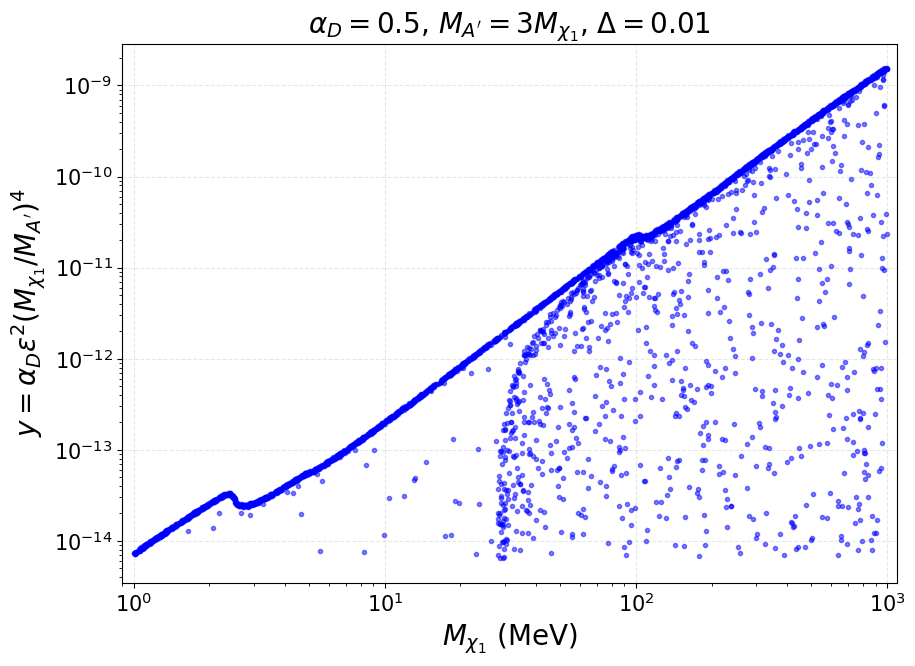

In [13]:
graficar_y(df_omega_0p01)

plt.title(r'$\alpha_{D} = 0.5\text{, } M_{A^{\prime}} = 3 M_{\chi_{1}}\text{, } \Delta = 0.01$',size=20)
plt.savefig('Delta0p01_alpha0p5.jpg',dpi=300)
plt.show()

In [14]:
df_omega_0p01.show(3)

MAp,Ms2,Mx1,st,gX,epsilon,yf,Mx2,Densidad reliquia,loglikelihood,delta,alphad,alphaf,mass_relative
8.40184,183.154,2.80061,0.0005,2.50663,1.99017e-06,0.00835543,2.82862,0.121,0.000465894,0.0280061,0.5,5.55556e-06,0.01
10.8332,34.4308,3.61105,0.0005,2.50663,2.32212e-06,0.00835543,3.64716,0.12,0,0.0361105,0.5,5.55556e-06,0.01
57.3524,3894.49,19.1175,0.0005,2.50663,1.10818e-05,0.00835543,19.3086,0.12,0,0.191175,0.5,5.55556e-06,0.01


In [15]:
def conversion_de_datos(df_):
    df = df_.copy()
    def multiplicador(df_a,label):
        df_a[label] = df_a.column(label) * 1e-3
        return df_a
    df = multiplicador(df_,'MAp')
    df = multiplicador(df_,'Ms2')
    df = multiplicador(df_,'Mx1')
    return df

In [16]:
df_omega_0p01_actualizado = conversion_de_datos(df_omega_0p01)
df_omega_0p01_actualizado.show(3)

df_omega_0p01_actualizado.to_csv(f'{path0p01}datos_densidad_reliquia_0p01.csv')

MAp,Ms2,Mx1,st,gX,epsilon,yf,Mx2,Densidad reliquia,loglikelihood,delta,alphad,alphaf,mass_relative
0.00840184,0.183154,0.00280061,0.0005,2.50663,1.99017e-06,0.00835543,2.82862,0.121,0.000465894,0.0280061,0.5,5.55556e-06,0.01
0.0108332,0.0344308,0.00361105,0.0005,2.50663,2.32212e-06,0.00835543,3.64716,0.12,0,0.0361105,0.5,5.55556e-06,0.01
0.0573524,3.89449,0.0191175,0.0005,2.50663,1.10818e-05,0.00835543,19.3086,0.12,0,0.191175,0.5,5.55556e-06,0.01


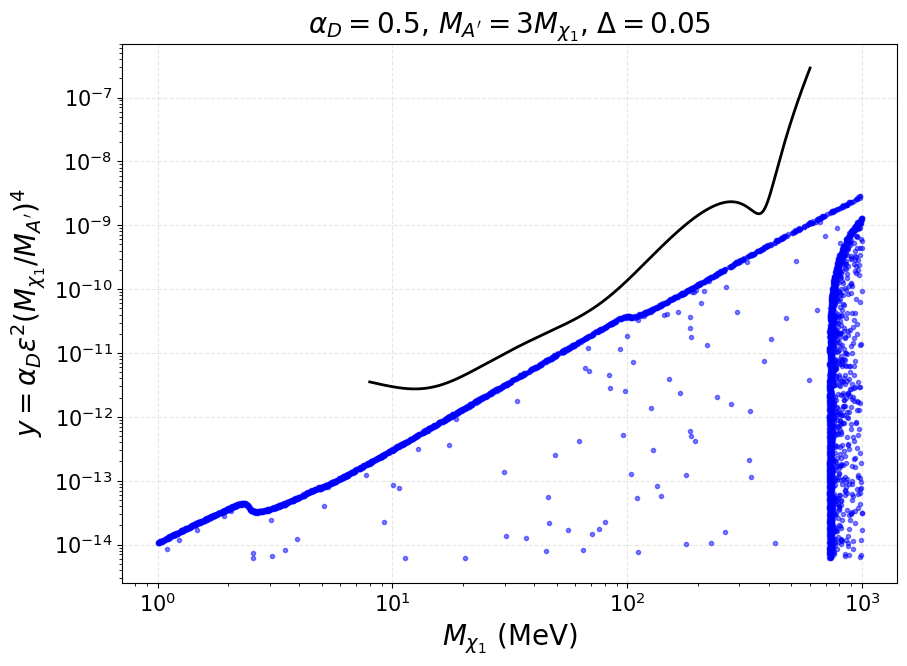

In [17]:
df = df_omega_0p05.copy()
alpha = df.column('alphad')[0]
ratio = round((df.column('Mx1') / df.column('MAp')).item(0),3)
factor = alpha * ratio**4 
plt.figure(figsize=(10,7))
plt.plot(df.column('Mx1'), df.column('epsilon')**2 * factor ,'.',color='blue',alpha=0.5)
x,y= extrapolacion(exclusion_0p05_alpha0p5,'mass','y',degree=6)
plt.plot(x*1e3, y*factor, '-', color='black', lw=2)
plt.xscale('log')
plt.yscale('log')
plt.ylabel(r'$y = \alpha_{D}\epsilon^2(M_{\chi_{1}}/M_{A^\prime})^{4}$',size=20)
plt.xlabel(r'$M_{\chi_{1}}$ (MeV)',size=20)
plt.grid(True, linestyle='--', alpha=0.3)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.title(r'$\alpha_{D} = 0.5\text{, } M_{A^{\prime}} = 3 M_{\chi_{1}}\text{, } \Delta = 0.05$',size=20)
plt.savefig('Delta0p05_alpha0p5.jpg',dpi=300)
plt.show()

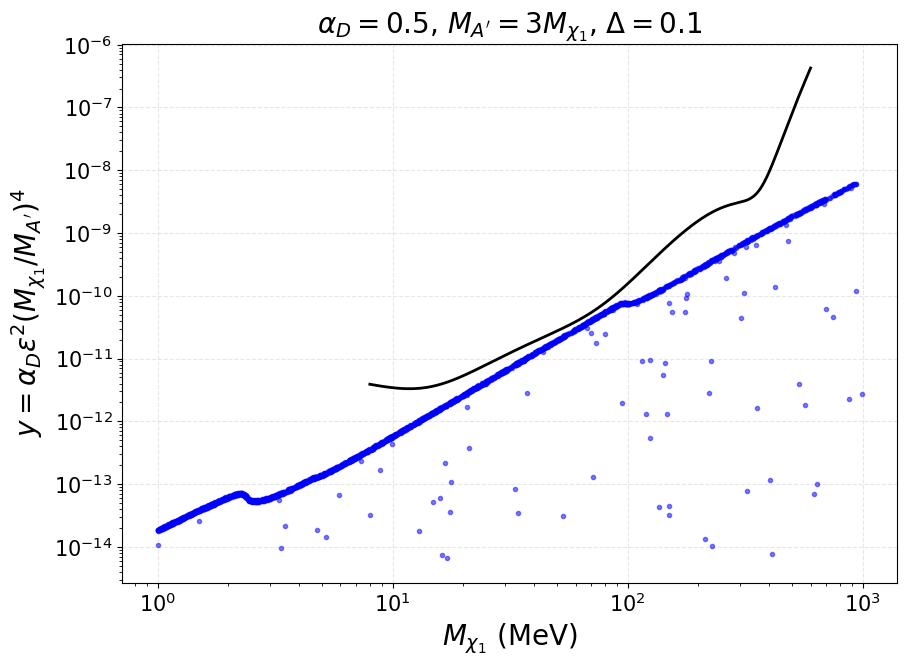

In [18]:
df = df_omega_0p1.copy()

alpha = df.column('alphad')[0]
ratio = round((df.column('Mx1') / df.column('MAp')).item(0),3)
factor = alpha * ratio**4 
plt.figure(figsize=(10,7))
plt.plot(df.column('Mx1'), df.column('epsilon')**2 * factor ,'.',color='blue',alpha=0.5)
x,y= extrapolacion(exclusion_0p1_alpha0p5,'mass','y',degree=6)
plt.plot(x*1e3, y*factor, '-', color='black', lw=2)
plt.xscale('log')
plt.yscale('log')
plt.ylabel(r'$y = \alpha_{D}\epsilon^2(M_{\chi_{1}}/M_{A^\prime})^{4}$',size=20)
plt.xlabel(r'$M_{\chi_{1}}$ (MeV)',size=20)
plt.grid(True, linestyle='--', alpha=0.3)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.title(r'$\alpha_{D} = 0.5\text{, } M_{A^{\prime}} = 3 M_{\chi_{1}}\text{, } \Delta = 0.1$',size=20)
plt.savefig('Delta0p1_alpha0p5.jpg',dpi=300)
plt.show()

In [19]:
'''
graficar_y(df_omega_0p01_alpha0p1)
plt.title(r'$\alpha_{D} = 0.1\text{, } M_{A^{\prime}} = 3 M_{\chi_{1}}\text{, } \Delta = 0.01$',size=20)
plt.savefig('Delta0p01_alpha0p1.jpg',dpi=300)
plt.show()
'''

<>:1: SyntaxWarning: invalid escape sequence '\p'
<>:1: SyntaxWarning: invalid escape sequence '\p'
/tmp/ipykernel_13117/915300278.py:1: SyntaxWarning: invalid escape sequence '\p'
  '''


"\ngraficar_y(df_omega_0p01_alpha0p1)\nplt.title(r'$\x07lpha_{D} = 0.1\text{, } M_{A^{\\prime}} = 3 M_{\\chi_{1}}\text{, } \\Delta = 0.01$',size=20)\nplt.savefig('Delta0p01_alpha0p1.jpg',dpi=300)\nplt.show()\n"

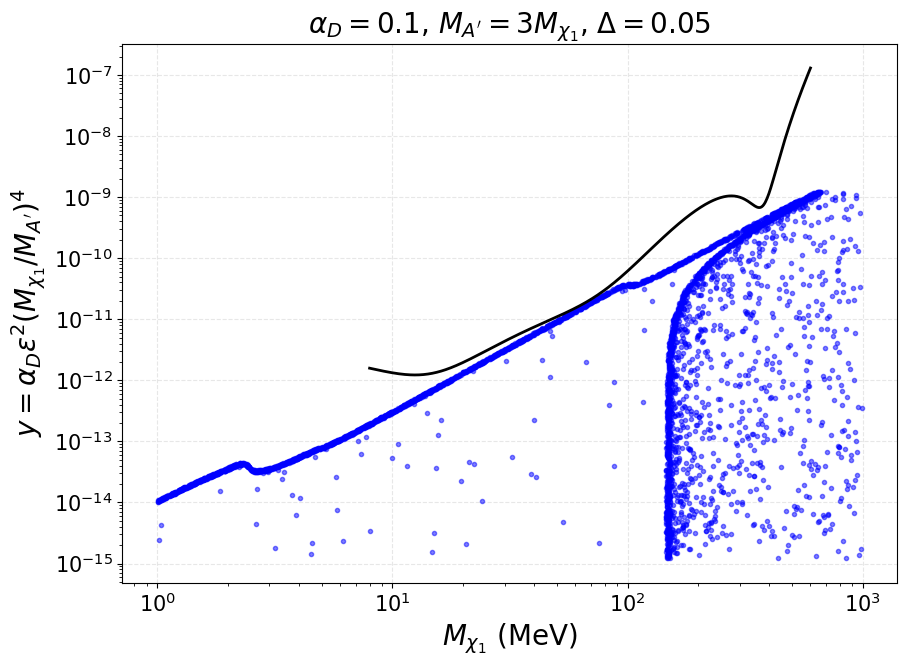

In [20]:
df = df_omega_0p05_alpha0p1.copy()
alpha = df.column('alphad')[0]
ratio = round((df.column('Mx1') / df.column('MAp')).item(0),3)
factor = alpha * ratio**4 
plt.figure(figsize=(10,7))
plt.plot(df.column('Mx1'), df.column('epsilon')**2 * factor ,'.',color='blue',alpha=0.5)
#plt.plot(exclusion_0p05_alpha0p1.column('mass')*1e3, exclusion_0p05_alpha0p1.column('y')*factor, '.', color='black')
x,y= extrapolacion(exclusion_0p05_alpha0p1,'mass','y',degree=6)
plt.plot(x*1e3, y*factor, '-', color='black', lw=2)
plt.xscale('log')
plt.yscale('log')
plt.ylabel(r'$y = \alpha_{D}\epsilon^2(M_{\chi_{1}}/M_{A^\prime})^{4}$',size=20)
plt.xlabel(r'$M_{\chi_{1}}$ (MeV)',size=20)
plt.grid(True, linestyle='--', alpha=0.3)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.title(r'$\alpha_{D} = 0.1\text{, } M_{A^{\prime}} = 3 M_{\chi_{1}}\text{, } \Delta = 0.05$',size=20)
plt.savefig('Delta0p05_alpha0p1.jpg',dpi=300)
plt.show()

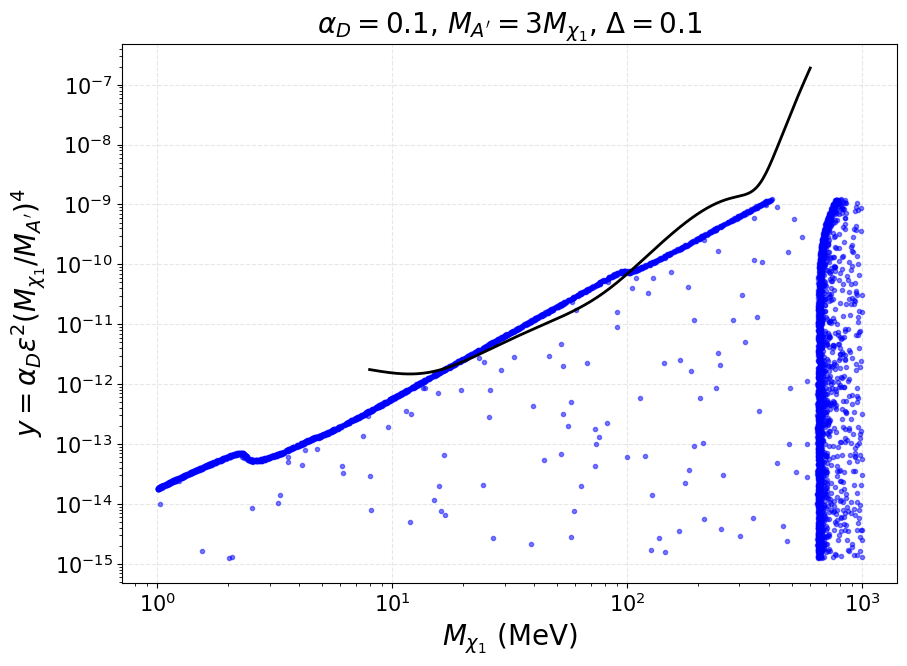

In [21]:
df = df_omega_0p1_alpha0p1.copy()
alpha = df.column('alphad')[0]
ratio = round((df.column('Mx1') / df.column('MAp')).item(0),3)
factor = alpha * ratio**4 
plt.figure(figsize=(10,7))
plt.plot(df.column('Mx1'), df.column('epsilon')**2 * factor ,'.',color='blue',alpha=0.5)
#plt.plot(exclusion_0p1_alpha0p1.column('mass')*1e3, exclusion_0p1_alpha0p1.column('y')*factor, '.', color='black')
x,y= extrapolacion(exclusion_0p1_alpha0p1,'mass','y',degree=6)
plt.plot(x*1e3, y*factor, '-', color='black', lw=2)
plt.xscale('log')
plt.yscale('log')
plt.ylabel(r'$y = \alpha_{D}\epsilon^2(M_{\chi_{1}}/M_{A^\prime})^{4}$',size=20)
plt.xlabel(r'$M_{\chi_{1}}$ (MeV)',size=20)
plt.grid(True, linestyle='--', alpha=0.3)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.title(r'$\alpha_{D} = 0.1\text{, } M_{A^{\prime}} = 3 M_{\chi_{1}}\text{, } \Delta = 0.1$',size=20)
plt.savefig('Delta0p1_alpha0p1.jpg',dpi=300)
plt.show()

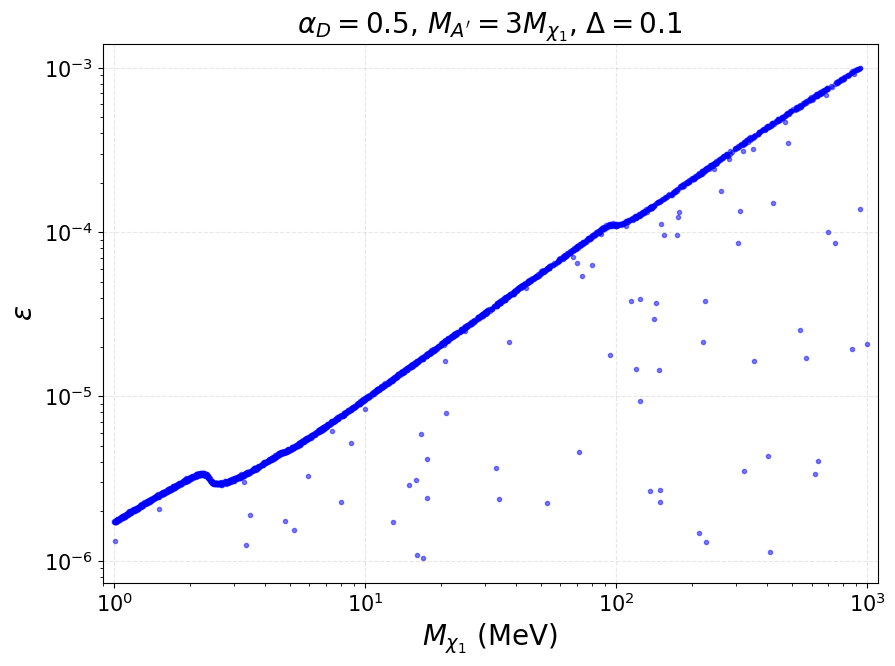

In [22]:
graficar_epsilon(df_omega_0p1)
plt.title(r'$\alpha_{D} = 0.5\text{, } M_{A^{\prime}} = 3 M_{\chi_{1}}\text{, } \Delta = 0.1$',size=20)
plt.show()

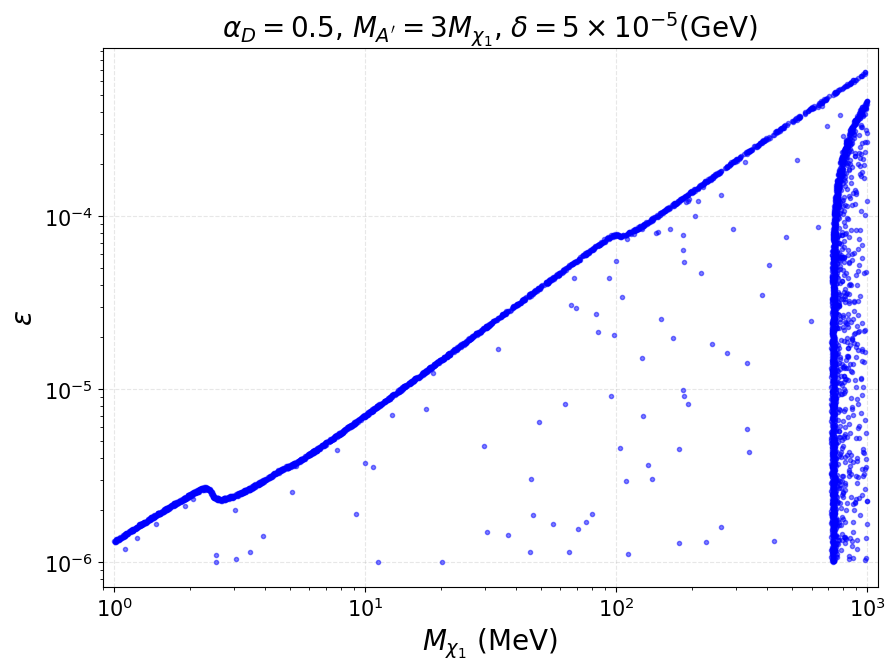

In [30]:
graficar_epsilon(df_omega_0p05)
plt.title(r'$\alpha_{D} = 0.5\text{, } M_{A^{\prime}} = 3 M_{\chi_{1}}\text{, } \delta = 5\times 10^{-5}$(GeV)',size=20)
plt.show()

In [31]:
graficar_epsilon(df_omega_0p5)
plt.title(r'$\alpha_{D} = 0.5\text{, } M_{A^{\prime}} = 3 M_{\chi_{1}}\text{, } \delta = 5\times 10^{-4}$(GeV)',size=20)
plt.show()

NameError: name 'df_omega_0p5' is not defined

In [ ]:
graficar_epsilon(df_omega_1)
plt.title(r'$\alpha_{D} = 0.5\text{, } M_{A^{\prime}} = 3 M_{\chi_{1}}\text{, } \delta = 1\times 10^{-3}$(GeV)',size=20)
plt.show()

In [ ]:
plt.figure(figsize=(10,7))
plt.plot(df_omega_0p01.column('Mx1'), df_omega_0p01.column('epsilon') ,'.',color='red',alpha=0.5,label=r'$\delta = 1\times 10^{-5}$')
plt.plot(df_omega_0p05.column('Mx1'), df_omega_0p05.column('epsilon') ,'.',color='blue',alpha=0.5,label=r'$\delta = 5\times 10^{-5}$')
plt.plot(df_omega_0p5.column('Mx1'), df_omega_0p5.column('epsilon') ,'+',color='red',alpha=0.5,label=r'$\delta = 5\times 10^{-4}$')
plt.plot(df_omega_1.column('Mx1'), df_omega_1.column('epsilon') ,'+',color='blue',alpha=0.5,label=r'$\delta = 1\times 10^{-3}$')
plt.xscale('log')
plt.yscale('log')
plt.ylabel(r'$\epsilon$',size=20)
plt.xlabel(r'$M_{\chi_{1}}$ (MeV)',size=20)
plt.grid(True, linestyle='--', alpha=0.3)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(fontsize=12, framealpha=0.9, loc='best')
#plt.title(r'$\Delta \geq 2m_{e}$',size=20)
plt.xlim(0.9,1e3+100)
plt.show()

In [ ]:
plt.figure(figsize=(10,7))
plt.plot(df_omega_0p01.column('Mx1'), df_omega_0p01.column('yf') ,'.',color='red',alpha=0.5,label=r'$\delta = 1\times 10^{-5}$')
plt.plot(df_omega_0p05.column('Mx1'), df_omega_0p05.column('yf') ,'.',color='blue',alpha=0.5,label=r'$\delta = 5\times 10^{-5}$')
plt.plot(df_omega_0p5.column('Mx1'), df_omega_0p5.column('yf') ,'+',color='darkblue',alpha=0.2,label=r'$\delta = 5\times 10^{-4}$')
plt.plot(df_omega_1.column('Mx1'), df_omega_1.column('yf') ,'+',color='darkred',alpha=0.2,label=r'$\delta = 1\times 10^{-3}$')
plt.xscale('log')
plt.yscale('log')
plt.ylabel(r'$yf$',size=20)
plt.xlabel(r'$M_{\chi_{1}}$ (MeV)',size=20)
plt.grid(True, linestyle='--', alpha=0.3)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(fontsize=12, framealpha=0.9, loc='best')
#plt.title(r'$\Delta \geq 2m_{e}$',size=20)
#plt.xlim(0.9,1e3+100)
plt.show()

In [ ]:
# Crear la figura con 4 subplots (2x2)
fig, axs = plt.subplots(2, 2, figsize=(14, 10))

# Subplot 1: δ = 1×10⁻⁵
axs[0, 0].plot(df_omega_0p01.column('Ms2'), df_omega_0p01.column('yf'), '.', 
               color='red', alpha=0.5, label=r'$\delta = 1\times 10^{-5}$')
axs[0, 0].set_xscale('log')
axs[0, 0].set_yscale('log')
axs[0, 0].set_ylabel(r'$yf$', size=15)
axs[0, 0].set_xlabel(r'$M_{\phi}$ (MeV)', size=15)
axs[0, 0].grid(True, linestyle='--', alpha=0.3)
axs[0, 0].tick_params(axis='both', which='major', labelsize=12)
axs[0, 0].legend(fontsize=10, framealpha=0.9, loc='best')
axs[0, 0].set_ylim(1e-7, 1)  # Límite corregido para este subplot

# Subplot 2: δ = 5×10⁻⁵
axs[0, 1].plot(df_omega_0p05.column('Ms2'), df_omega_0p05.column('yf'), '.', 
               color='blue', alpha=0.5, label=r'$\delta = 5\times 10^{-5}$')
axs[0, 1].set_xscale('log')
axs[0, 1].set_yscale('log')
axs[0, 1].set_ylabel(r'$yf$', size=15)
axs[0, 1].set_xlabel(r'$M_{\phi}$ (MeV)', size=15)
axs[0, 1].grid(True, linestyle='--', alpha=0.3)
axs[0, 1].tick_params(axis='both', which='major', labelsize=12)
axs[0, 1].legend(fontsize=10, framealpha=0.9, loc='best')
axs[0, 1].set_ylim(1e-7, 1)  # Límite corregido para este subplot

# Subplot 3: δ = 5×10⁻⁴
axs[1, 0].plot(df_omega_0p5.column('Ms2'), df_omega_0p5.column('yf'), '+', 
               color='darkblue', alpha=0.5, label=r'$\delta = 5\times 10^{-4}$')
axs[1, 0].set_xscale('log')
axs[1, 0].set_yscale('log')
axs[1, 0].set_ylabel(r'$yf$', size=15)
axs[1, 0].set_xlabel(r'$M_{\phi}$ (MeV)', size=15)
axs[1, 0].grid(True, linestyle='--', alpha=0.3)
axs[1, 0].tick_params(axis='both', which='major', labelsize=12)
axs[1, 0].legend(fontsize=10, framealpha=0.9, loc='best')
axs[1, 0].set_ylim(1e-7, 1) # Límite corregido para este subplot

# Subplot 4: δ = 1×10⁻³
axs[1, 1].plot(df_omega_1.column('Ms2'), df_omega_1.column('yf'), '+', 
              color='darkred', alpha=0.5, label=r'$\delta = 1\times 10^{-3}$')
axs[1, 1].set_xscale('log')
axs[1, 1].set_yscale('log')
axs[1, 1].set_ylabel(r'$yf$', size=15)
axs[1, 1].set_xlabel(r'$M_{\phi}$ (MeV)', size=15)
axs[1, 1].grid(True, linestyle='--', alpha=0.3)
axs[1, 1].tick_params(axis='both', which='major', labelsize=12)
axs[1, 1].legend(fontsize=10, framealpha=0.9, loc='best')
axs[1, 1].set_ylim(1e-7, 1)  # Límite corregido para este subplot

# Ajustar el espaciado entre subplots
plt.tight_layout()
plt.show()

In [ ]:
# Crear la figura con 4 subplots (2x2)
fig, axs = plt.subplots(2, 2, figsize=(14, 10))

fig.suptitle('Grafico comparativo entre algoritmo random y DE',size=20, y=0.98)
# Subplot 1: δ = 1×10⁻⁵
axs[0, 0].set_title(r'$\delta = 1\times 10^{-5}$',size=15)
axs[0, 0].plot(df_omega_0p01.column('Mx1'), df_omega_0p01.column('epsilon'), '+', 
               color='red', alpha=0.5, label=r'Random')
axs[0, 0].plot(df_omega_0p01_de.column('Mx1'), df_omega_0p01_de.column('epsilon'), '.', 
               color='blue', alpha=0.5, label=r'DE')
axs[0, 0].set_xscale('log')
axs[0, 0].set_yscale('log')
axs[0, 0].set_ylabel(r'$\epsilon$', size=15)
axs[0, 0].set_xlabel(r'$M_{\chi_{1}}$ (MeV)', size=15)
axs[0, 0].grid(True, linestyle='--', alpha=0.3)
axs[0, 0].tick_params(axis='both', which='major', labelsize=12)
axs[0, 0].legend(fontsize=10, framealpha=0.9, loc='best')
axs[0, 0].set_xlim(0.9, 1e3+100)  # Límite corregido para este subplot

# Subplot 2: δ = 5×10⁻⁵
axs[0, 1].set_title(r'$\delta = 5\times 10^{-5}$',size=15)
axs[0, 1].plot(df_omega_0p05.column('Mx1'), df_omega_0p05.column('epsilon'), '+', 
               color='red', alpha=0.5, label=r'Random')
axs[0, 1].plot(df_omega_0p05_de.column('Mx1'), df_omega_0p05_de.column('epsilon'), '.', 
               color='blue', alpha=0.5, label=r'DE')
axs[0, 1].set_xscale('log')
axs[0, 1].set_yscale('log')
axs[0, 1].set_ylabel(r'$\epsilon$', size=15)
axs[0, 1].set_xlabel(r'$M_{\chi_1}$ (MeV)', size=15)
axs[0, 1].grid(True, linestyle='--', alpha=0.3)
axs[0, 1].tick_params(axis='both', which='major', labelsize=12)
axs[0, 1].legend(fontsize=10, framealpha=0.9, loc='best')
axs[0, 1].set_xlim(0.9, 1e3+100)  # Límite corregido para este subplot

# Subplot 3: δ = 5×10⁻⁴
axs[1, 0].set_title(r'$\delta = 5\times 10^{-4}$',size=15)
axs[1, 0].plot(df_omega_0p5.column('Mx1'), df_omega_0p5.column('epsilon'), '+', 
               color='red', alpha=0.5, label=r'Random')
axs[1, 0].plot(df_omega_0p5_de.column('Mx1'), df_omega_0p5_de.column('epsilon'), '.', 
               color='blue', alpha=0.5, label=r'DE')
axs[1, 0].set_xscale('log')
axs[1, 0].set_yscale('log')
axs[1, 0].set_ylabel(r'$\epsilon$', size=15)
axs[1, 0].set_xlabel(r'$M_{\chi_1}$ (MeV)', size=15)
axs[1, 0].grid(True, linestyle='--', alpha=0.3)
axs[1, 0].tick_params(axis='both', which='major', labelsize=12)
axs[1, 0].legend(fontsize=10, framealpha=0.9, loc='best')
axs[1, 0].set_xlim(0.9, 1e3+100) # Límite corregido para este subplot

# Subplot 4: δ = 1×10⁻³
axs[1, 1].set_title(r'$\delta = 1\times 10^{-3}$',size=15)
axs[1, 1].plot(df_omega_1.column('Mx1'), df_omega_1.column('epsilon'), '+', 
              color='red', alpha=0.5, label=r'Random')
axs[1, 1].plot(df_omega_1_de.column('Mx1'), df_omega_1_de.column('epsilon'), '.', 
              color='blue', alpha=0.5, label=r'DE')
axs[1, 1].set_xscale('log')
axs[1, 1].set_yscale('log')
axs[1, 1].set_ylabel(r'$\epsilon$', size=15)
axs[1, 1].set_xlabel(r'$M_{\chi_1}$ (MeV)', size=15)
axs[1, 1].grid(True, linestyle='--', alpha=0.3)
axs[1, 1].tick_params(axis='both', which='major', labelsize=12)
axs[1, 1].legend(fontsize=10, framealpha=0.9, loc='best')
axs[1, 1].set_xlim(0.9, 1e3+100)  # Límite corregido para este subplot

# Ajustar el espaciado entre subplots
plt.tight_layout()
plt.savefig('grafico_comparativo.jpg', dpi=300)
plt.show()

In [ ]:
# Crear la figura con 2 subplots en una fila (1x2)
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

fig.suptitle('Gráfico comparativo entre algoritmo random y DE', size=20, y=0.98)

# Subplot 1: δ = 1×10⁻⁵
axs[0].set_title(r'$\delta = 1\times 10^{-5}$', size=15)
axs[0].plot(df_omega_0p01.column('Mx1'), df_omega_0p01.column('epsilon'), '+', 
           color='red', alpha=0.5, label=r'Random')
axs[0].plot(df_omega_0p01_idm.column('Mx1'), df_omega_0p01_idm.column('epsilon'), '.', 
           color='black', alpha=0.5, label=r'iDM')
axs[0].set_xscale('log')
axs[0].set_yscale('log')
axs[0].set_ylabel(r'$\epsilon$', size=15)
axs[0].set_xlabel(r'$M_{\chi_{1}}$ (MeV)', size=15)
axs[0].grid(True, linestyle='--', alpha=0.3)
axs[0].tick_params(axis='both', which='major', labelsize=12)
axs[0].legend(fontsize=10, framealpha=0.9, loc='best')
axs[0].set_xlim(0.9, 1e3+100)

# Subplot 2: δ = 5×10⁻⁵
axs[1].set_title(r'$\delta = 1\times 10^{-5}$', size=15)
axs[1].plot(df_omega_0p01_de.column('Mx1'), df_omega_0p01_de.column('epsilon'), '+', 
           color='blue', alpha=0.5, label=r'DE')
axs[1].plot(df_omega_0p01_idm.column('Mx1'), df_omega_0p01_idm.column('epsilon'), '.', 
           color='black', alpha=0.5, label=r'iDM')
axs[1].set_xscale('log')
axs[1].set_yscale('log')
axs[1].set_ylabel(r'$\epsilon$', size=15)
axs[1].set_xlabel(r'$M_{\chi_1}$ (MeV)', size=15)
axs[1].grid(True, linestyle='--', alpha=0.3)
axs[1].tick_params(axis='both', which='major', labelsize=12)
axs[1].legend(fontsize=10, framealpha=0.9, loc='best')
axs[1].set_xlim(0.9, 1e3+100)

# Ajustar el espaciado entre subplots
plt.tight_layout()
plt.savefig('grafico_delta0p01.jpg',dpi=300)
plt.show()

In [ ]:
# Crear la figura con 2 subplots en una fila (1x2)
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

fig.suptitle('Gráfico comparativo entre algoritmo random y DE', size=20, y=0.98)

# Subplot 1: δ = 1×10⁻⁵
axs[0].set_title(r'$\delta = 5\times 10^{-5}$', size=15)
axs[0].plot(df_omega_0p05.column('Mx1'), df_omega_0p05.column('epsilon'), '+', 
           color='red', alpha=0.5, label=r'Random')
axs[0].plot(df_omega_0p05_idm.column('Mx1'), df_omega_0p05_idm.column('epsilon'), '.', 
           color='black', alpha=0.5, label=r'iDM')
axs[0].set_xscale('log')
axs[0].set_yscale('log')
axs[0].set_ylabel(r'$\epsilon$', size=15)
axs[0].set_xlabel(r'$M_{\chi_{1}}$ (MeV)', size=15)
axs[0].grid(True, linestyle='--', alpha=0.3)
axs[0].tick_params(axis='both', which='major', labelsize=12)
axs[0].legend(fontsize=10, framealpha=0.9, loc='best')
axs[0].set_xlim(0.9, 1e3+100)

# Subplot 2: δ = 5×10⁻⁵
axs[1].set_title(r'$\delta = 5\times 10^{-5}$', size=15)
axs[1].plot(df_omega_0p05_de.column('Mx1'), df_omega_0p05_de.column('epsilon'), '+', 
           color='blue', alpha=0.5, label=r'DE')
axs[1].plot(df_omega_0p05_idm.column('Mx1'), df_omega_0p05_idm.column('epsilon'), '.', 
           color='black', alpha=0.5, label=r'iDM')
axs[1].set_xscale('log')
axs[1].set_yscale('log')
axs[1].set_ylabel(r'$\epsilon$', size=15)
axs[1].set_xlabel(r'$M_{\chi_1}$ (MeV)', size=15)
axs[1].grid(True, linestyle='--', alpha=0.3)
axs[1].tick_params(axis='both', which='major', labelsize=12)
axs[1].legend(fontsize=10, framealpha=0.9, loc='best')
axs[1].set_xlim(0.9, 1e3+100)

# Ajustar el espaciado entre subplots
plt.tight_layout()
plt.savefig('grafico_delta0p05.jpg',dpi=300)
plt.show()

In [ ]:
# Crear la figura con 2 subplots en una fila (1x2)
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

fig.suptitle('Gráfico comparativo entre algoritmo random y DE', size=20, y=0.98)

# Subplot 1: δ = 1×10⁻⁵
axs[0].set_title(r'$\delta = 5\times 10^{-4}$', size=15)
axs[0].plot(df_omega_0p5.column('Mx1'), df_omega_0p5.column('epsilon'), '+', 
           color='red', alpha=0.5, label=r'Random')
axs[0].plot(df_omega_0p5_idm.column('Mx1'), df_omega_0p5_idm.column('epsilon'), '.', 
           color='black', alpha=0.5, label=r'iDM')
axs[0].set_xscale('log')
axs[0].set_yscale('log')
axs[0].set_ylabel(r'$\epsilon$', size=15)
axs[0].set_xlabel(r'$M_{\chi_{1}}$ (MeV)', size=15)
axs[0].grid(True, linestyle='--', alpha=0.3)
axs[0].tick_params(axis='both', which='major', labelsize=12)
axs[0].legend(fontsize=10, framealpha=0.9, loc='best')
axs[0].set_xlim(0.9, 1e3+100)

# Subplot 2: δ = 5×10⁻⁵
axs[1].set_title(r'$\delta = 5\times 10^{-4}$', size=15)
axs[1].plot(df_omega_0p5_de.column('Mx1'), df_omega_0p5_de.column('epsilon'), '+', 
           color='blue', alpha=0.5, label=r'DE')
axs[1].plot(df_omega_0p5_idm.column('Mx1'), df_omega_0p5_idm.column('epsilon'), '.', 
           color='black', alpha=0.5, label=r'iDM')
axs[1].set_xscale('log')
axs[1].set_yscale('log')
axs[1].set_ylabel(r'$\epsilon$', size=15)
axs[1].set_xlabel(r'$M_{\chi_1}$ (MeV)', size=15)
axs[1].grid(True, linestyle='--', alpha=0.3)
axs[1].tick_params(axis='both', which='major', labelsize=12)
axs[1].legend(fontsize=10, framealpha=0.9, loc='best')
axs[1].set_xlim(0.9, 1e3+100)

# Ajustar el espaciado entre subplots
plt.tight_layout()
plt.savefig('grafico_delta0p5.jpg',dpi=300)
plt.show()

In [ ]:
# Crear la figura con 2 subplots en una fila (1x2)
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

fig.suptitle('Gráfico comparativo entre algoritmo random y DE', size=20, y=0.98)

# Subplot 1: δ = 1×10⁻⁵
axs[0].set_title(r'$\delta = 1\times 10^{-3}$', size=15)
axs[0].plot(df_omega_1.column('Mx1'), df_omega_1.column('epsilon'), '+', 
           color='red', alpha=0.5, label=r'Random')
axs[0].plot(df_omega_1_idm.column('Mx1'), df_omega_1_idm.column('epsilon'), '.', 
           color='black', alpha=0.5, label=r'iDM')
axs[0].set_xscale('log')
axs[0].set_yscale('log')
axs[0].set_ylabel(r'$\epsilon$', size=15)
axs[0].set_xlabel(r'$M_{\chi_{1}}$ (MeV)', size=15)
axs[0].grid(True, linestyle='--', alpha=0.3)
axs[0].tick_params(axis='both', which='major', labelsize=12)
axs[0].legend(fontsize=10, framealpha=0.9, loc='best')
axs[0].set_xlim(0.9, 1e3+100)

# Subplot 2: δ = 5×10⁻⁵
axs[1].set_title(r'$\delta = 1\times 10^{-3}$', size=15)
axs[1].plot(df_omega_1_de.column('Mx1'), df_omega_1_de.column('epsilon'), '+', 
           color='blue', alpha=0.5, label=r'DE')
axs[1].plot(df_omega_1_idm.column('Mx1'), df_omega_1_idm.column('epsilon'), '.', 
           color='black', alpha=0.5, label=r'iDM')
axs[1].set_xscale('log')
axs[1].set_yscale('log')
axs[1].set_ylabel(r'$\epsilon$', size=15)
axs[1].set_xlabel(r'$M_{\chi_1}$ (MeV)', size=15)
axs[1].grid(True, linestyle='--', alpha=0.3)
axs[1].tick_params(axis='both', which='major', labelsize=12)
axs[1].legend(fontsize=10, framealpha=0.9, loc='best')
axs[1].set_xlim(0.9, 1e3+100)

# Ajustar el espaciado entre subplots
plt.tight_layout()
plt.savefig('grafico_delta1.jpg',dpi=300)
plt.show()